In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from tensorflow.keras.layers import Input, concatenate,Dense
from keras.models import Sequential,Model
from keras.layers import Concatenate, Dense,Input, concatenate,Dropout,Flatten
from sklearn.model_selection import KFold

In [3]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.2*4000=800

# spatial slicing dimensions
os = 8 # output slice size
halo = 2 # edge cells
ts = os + halo * 2 # total input slice size including halos 12
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 511  # number of slices in one profile 



In [4]:
print(train_size,test_size)

3200 800


In [5]:
#spatial slicing the 4000 profiles 

image=np.zeros((l2r*num,ts,3)) 
label=np.zeros((l2r*num,os)) 

#cut each profile into 4066 slices. 
#label: tau channel of the center of each slice(reduced domain)
for i in range(num):
    for n in range(l2r):
        img= data[i,n*os:n*os+ts, 0:nchan] #input: 12 pixels for one slice, 3 channels 
        lb = data[i,n*os+halo:n*os+halo+os, nchan] #8 pixels for label,the tau channel is the label
        image[i*l2r+n]=img
        label[i*l2r+n]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #4066*4000=16264000


whole dataset features size:  (2044000, 12, 3) whole dataset label size:  (2044000, 8)


In [6]:
predictions = np.empty((test_size,8)) 
predictions.shape

(800, 8)

In [42]:
# DNN over domain -------------------------------------------

def evaluate_model(train_image, test_image, train_label, test_label):

    input_img = Input(shape=(ts,nchan))
    hn=Flatten()(input_img)
    hn = Dense(8, activation='relu')(hn)#1st fully connected layer
    hn1 =Dense(1024, activation='relu')(hn)
    hn1=Dense(1024, activation='relu')(hn1)
    hn1=Dropout(0.5)(hn1)
    hn1=Dense(8, activation='relu')(hn1) #4th fully connected layer
    out_both = concatenate([hn, hn1], axis=1, name = 'concatenate')
    hn2=Dense(8, activation='linear')(out_both)
    model_m = Model(input_img, outputs=[hn2])
    model_m.summary()


    ltype = 'mean_squared_error'
    ltype2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 1024
    eps = 2000

    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,ltype2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience = 50,restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------
    print('test result')

    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)
    mse = results[0]
    rmse=results[2]
    
    return model_m,rmse,mse,history,predictions

In [43]:
#5 folds cross validation 

n_folds=5
kf = KFold(n_splits=n_folds)
kf.get_n_splits(image)
print(kf)
ratio=int(image.shape[0]/n_folds)
print('ratio:',ratio)
print('train folds data number:',ratio*4)
print('test fold data number:',ratio)


KFold(n_splits=5, random_state=None, shuffle=False)
ratio: 408800
train folds data number: 1635200
test fold data number: 408800


In [44]:
cv_scores= list()
cv_scores2=list()
model_history=list()

count=1
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_image, test_image = image[train_index], image[test_index]
    train_label, test_label = label[train_index], label[test_index]

    model_m,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(count)+' : '+str(mse))
    print('RMSE on test set in fold'+str(count)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

    count+=1
    

TRAIN: [ 408800  408801  408802 ... 2043997 2043998 2043999] TEST: [     0      1      2 ... 408797 408798 408799]
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 12, 3)]      0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 36)           0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 8)            296         flatten_6[0][0]                  
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 1024)         9216        dense_30[0]

Epoch 58/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.5636 - mean_squared_error: 19.5636 - root_mean_squared_error: 4.4229 - val_loss: 16.0327 - val_mean_squared_error: 16.0327 - val_root_mean_squared_error: 4.0041
Epoch 59/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.4518 - mean_squared_error: 19.4518 - root_mean_squared_error: 4.4103 - val_loss: 15.7376 - val_mean_squared_error: 15.7376 - val_root_mean_squared_error: 3.9671
Epoch 60/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.4601 - mean_squared_error: 19.4601 - root_mean_squared_error: 4.4112 - val_loss: 16.1993 - val_mean_squared_error: 16.1993 - val_root_mean_squared_error: 4.0248
Epoch 61/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.3169 - mean_squared_error: 19.3169 - root_mean_squared_error: 4.3950 - val_loss: 16.3884 - val_mean_squared_error: 16.3884 - val_root_mean_squared_error: 4.0483
Epoch 62/2000
1398/1398 [===

Epoch 92/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.1522 - mean_squared_error: 19.1522 - root_mean_squared_error: 4.3762 - val_loss: 15.6470 - val_mean_squared_error: 15.6470 - val_root_mean_squared_error: 3.9556
Epoch 93/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.2795 - mean_squared_error: 19.2795 - root_mean_squared_error: 4.3906 - val_loss: 16.0535 - val_mean_squared_error: 16.0535 - val_root_mean_squared_error: 4.0067
Epoch 94/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.1102 - mean_squared_error: 19.1102 - root_mean_squared_error: 4.3714 - val_loss: 18.1726 - val_mean_squared_error: 18.1726 - val_root_mean_squared_error: 4.2629
Epoch 95/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.4248 - mean_squared_error: 19.4248 - root_mean_squared_error: 4.4072 - val_loss: 16.0959 - val_mean_squared_error: 16.0959 - val_root_mean_squared_error: 4.0120
Epoch 96/2000
1398/1398 [===

Epoch 126/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 18.9822 - mean_squared_error: 18.9822 - root_mean_squared_error: 4.3568 - val_loss: 15.7578 - val_mean_squared_error: 15.7578 - val_root_mean_squared_error: 3.9696
Epoch 127/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.1967 - mean_squared_error: 19.1967 - root_mean_squared_error: 4.3811 - val_loss: 15.5879 - val_mean_squared_error: 15.5879 - val_root_mean_squared_error: 3.9481
Epoch 128/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 18.7509 - mean_squared_error: 18.7509 - root_mean_squared_error: 4.3300 - val_loss: 15.6509 - val_mean_squared_error: 15.6509 - val_root_mean_squared_error: 3.9561
Epoch 129/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 19.3608 - mean_squared_error: 19.3608 - root_mean_squared_error: 4.3999 - val_loss: 15.5885 - val_mean_squared_error: 15.5885 - val_root_mean_squared_error: 3.9482
Epoch 130/2000
1398/1398

Epoch 193/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.4003 - mean_squared_error: 14.4003 - root_mean_squared_error: 3.7947 - val_loss: 11.6765 - val_mean_squared_error: 11.6765 - val_root_mean_squared_error: 3.4171
Epoch 194/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.4289 - mean_squared_error: 14.4289 - root_mean_squared_error: 3.7984 - val_loss: 12.0825 - val_mean_squared_error: 12.0825 - val_root_mean_squared_error: 3.4760
Epoch 195/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.1101 - mean_squared_error: 14.1101 - root_mean_squared_error: 3.7562 - val_loss: 12.2100 - val_mean_squared_error: 12.2100 - val_root_mean_squared_error: 3.4943
Epoch 196/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.1388 - mean_squared_error: 14.1388 - root_mean_squared_error: 3.7600 - val_loss: 11.7713 - val_mean_squared_error: 11.7713 - val_root_mean_squared_error: 3.4309
Epoch 197/2000
1398/1398

Epoch 260/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7685 - mean_squared_error: 13.7685 - root_mean_squared_error: 3.7103 - val_loss: 11.5969 - val_mean_squared_error: 11.5969 - val_root_mean_squared_error: 3.4054
Epoch 261/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7051 - mean_squared_error: 13.7051 - root_mean_squared_error: 3.7020 - val_loss: 13.4069 - val_mean_squared_error: 13.4069 - val_root_mean_squared_error: 3.6615
Epoch 262/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8838 - mean_squared_error: 13.8838 - root_mean_squared_error: 3.7260 - val_loss: 11.5005 - val_mean_squared_error: 11.5005 - val_root_mean_squared_error: 3.3912
Epoch 263/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7095 - mean_squared_error: 13.7095 - root_mean_squared_error: 3.7025 - val_loss: 12.0952 - val_mean_squared_error: 12.0952 - val_root_mean_squared_error: 3.4778
Epoch 264/2000
1398/1398

Epoch 327/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.0369 - mean_squared_error: 14.0369 - root_mean_squared_error: 3.7462 - val_loss: 11.8084 - val_mean_squared_error: 11.8084 - val_root_mean_squared_error: 3.4363
Epoch 328/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6256 - mean_squared_error: 13.6256 - root_mean_squared_error: 3.6912 - val_loss: 11.4817 - val_mean_squared_error: 11.4817 - val_root_mean_squared_error: 3.3885
Epoch 329/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6191 - mean_squared_error: 13.6191 - root_mean_squared_error: 3.6902 - val_loss: 11.5981 - val_mean_squared_error: 11.5981 - val_root_mean_squared_error: 3.4056
Epoch 330/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7244 - mean_squared_error: 13.7244 - root_mean_squared_error: 3.7044 - val_loss: 11.5350 - val_mean_squared_error: 11.5350 - val_root_mean_squared_error: 3.3963
Epoch 331/2000
1398/1398

Epoch 394/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4388 - mean_squared_error: 13.4388 - root_mean_squared_error: 3.6657 - val_loss: 11.5012 - val_mean_squared_error: 11.5012 - val_root_mean_squared_error: 3.3913
Epoch 395/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6012 - mean_squared_error: 13.6012 - root_mean_squared_error: 3.6878 - val_loss: 11.3993 - val_mean_squared_error: 11.3993 - val_root_mean_squared_error: 3.3763
Epoch 396/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4151 - mean_squared_error: 13.4151 - root_mean_squared_error: 3.6624 - val_loss: 11.5244 - val_mean_squared_error: 11.5244 - val_root_mean_squared_error: 3.3948
Epoch 397/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4548 - mean_squared_error: 13.4548 - root_mean_squared_error: 3.6674 - val_loss: 11.6381 - val_mean_squared_error: 11.6381 - val_root_mean_squared_error: 3.4115
Epoch 398/2000
1398/1398

1398/1398 [==============================] - 8s 5ms/step - loss: 28.6084 - mean_squared_error: 28.6084 - root_mean_squared_error: 5.2818 - val_loss: 16.9666 - val_mean_squared_error: 16.9666 - val_root_mean_squared_error: 4.1191
Epoch 2/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 20.6790 - mean_squared_error: 20.6790 - root_mean_squared_error: 4.5473 - val_loss: 16.9534 - val_mean_squared_error: 16.9534 - val_root_mean_squared_error: 4.1175
Epoch 3/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 20.5323 - mean_squared_error: 20.5323 - root_mean_squared_error: 4.5311 - val_loss: 16.7208 - val_mean_squared_error: 16.7208 - val_root_mean_squared_error: 4.0891
Epoch 4/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 20.4165 - mean_squared_error: 20.4165 - root_mean_squared_error: 4.5184 - val_loss: 16.8213 - val_mean_squared_error: 16.8213 - val_root_mean_squared_error: 4.1014
Epoch 5/2000
1398/1398 [=====================

Epoch 35/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 16.7624 - mean_squared_error: 16.7624 - root_mean_squared_error: 4.0938 - val_loss: 13.6566 - val_mean_squared_error: 13.6566 - val_root_mean_squared_error: 3.6955
Epoch 36/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 16.1377 - mean_squared_error: 16.1377 - root_mean_squared_error: 4.0171 - val_loss: 13.4009 - val_mean_squared_error: 13.4009 - val_root_mean_squared_error: 3.6607
Epoch 37/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 15.8195 - mean_squared_error: 15.8195 - root_mean_squared_error: 3.9770 - val_loss: 13.1756 - val_mean_squared_error: 13.1756 - val_root_mean_squared_error: 3.6298
Epoch 38/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 15.6216 - mean_squared_error: 15.6216 - root_mean_squared_error: 3.9520 - val_loss: 13.0642 - val_mean_squared_error: 13.0642 - val_root_mean_squared_error: 3.6144
Epoch 39/2000
1398/1398 [===

Epoch 69/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.2309 - mean_squared_error: 14.2309 - root_mean_squared_error: 3.7722 - val_loss: 12.3353 - val_mean_squared_error: 12.3353 - val_root_mean_squared_error: 3.5122
Epoch 70/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 14.4206 - mean_squared_error: 14.4206 - root_mean_squared_error: 3.7973 - val_loss: 12.4759 - val_mean_squared_error: 12.4759 - val_root_mean_squared_error: 3.5321
Epoch 71/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 14.6251 - mean_squared_error: 14.6251 - root_mean_squared_error: 3.8234 - val_loss: 12.3872 - val_mean_squared_error: 12.3872 - val_root_mean_squared_error: 3.5195
Epoch 72/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 14.6679 - mean_squared_error: 14.6679 - root_mean_squared_error: 3.8297 - val_loss: 12.6799 - val_mean_squared_error: 12.6799 - val_root_mean_squared_error: 3.5609
Epoch 73/2000
1398/1398 [===

Epoch 103/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.3223 - mean_squared_error: 14.3223 - root_mean_squared_error: 3.7839 - val_loss: 12.2806 - val_mean_squared_error: 12.2806 - val_root_mean_squared_error: 3.5044
Epoch 104/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.1765 - mean_squared_error: 14.1765 - root_mean_squared_error: 3.7647 - val_loss: 13.7402 - val_mean_squared_error: 13.7402 - val_root_mean_squared_error: 3.7068
Epoch 105/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.1513 - mean_squared_error: 14.1513 - root_mean_squared_error: 3.7616 - val_loss: 12.2777 - val_mean_squared_error: 12.2777 - val_root_mean_squared_error: 3.5040
Epoch 106/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.1749 - mean_squared_error: 14.1749 - root_mean_squared_error: 3.7648 - val_loss: 12.5044 - val_mean_squared_error: 12.5044 - val_root_mean_squared_error: 3.5361
Epoch 107/2000
1398/1398

Epoch 170/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7478 - mean_squared_error: 13.7478 - root_mean_squared_error: 3.7076 - val_loss: 13.1516 - val_mean_squared_error: 13.1516 - val_root_mean_squared_error: 3.6265
Epoch 171/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.0780 - mean_squared_error: 14.0780 - root_mean_squared_error: 3.7520 - val_loss: 12.3560 - val_mean_squared_error: 12.3560 - val_root_mean_squared_error: 3.5151
Epoch 172/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.2008 - mean_squared_error: 14.2008 - root_mean_squared_error: 3.7678 - val_loss: 12.3818 - val_mean_squared_error: 12.3818 - val_root_mean_squared_error: 3.5188
Epoch 173/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7443 - mean_squared_error: 13.7443 - root_mean_squared_error: 3.7071 - val_loss: 13.4347 - val_mean_squared_error: 13.4347 - val_root_mean_squared_error: 3.6653
Epoch 174/2000
1398/1398

Epoch 46/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.7218 - mean_squared_error: 14.7218 - root_mean_squared_error: 3.8367 - val_loss: 12.2640 - val_mean_squared_error: 12.2640 - val_root_mean_squared_error: 3.5020
Epoch 47/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 14.5987 - mean_squared_error: 14.5987 - root_mean_squared_error: 3.8207 - val_loss: 11.7780 - val_mean_squared_error: 11.7780 - val_root_mean_squared_error: 3.4319
Epoch 48/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.5779 - mean_squared_error: 14.5779 - root_mean_squared_error: 3.8180 - val_loss: 12.3333 - val_mean_squared_error: 12.3333 - val_root_mean_squared_error: 3.5119
Epoch 49/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.6630 - mean_squared_error: 14.6630 - root_mean_squared_error: 3.8291 - val_loss: 12.0657 - val_mean_squared_error: 12.0657 - val_root_mean_squared_error: 3.4736
Epoch 50/2000
1398/1398 [===

Epoch 80/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.9771 - mean_squared_error: 13.9771 - root_mean_squared_error: 3.7385 - val_loss: 11.4660 - val_mean_squared_error: 11.4660 - val_root_mean_squared_error: 3.3861
Epoch 81/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 13.5047 - mean_squared_error: 13.5047 - root_mean_squared_error: 3.6746 - val_loss: 11.2375 - val_mean_squared_error: 11.2375 - val_root_mean_squared_error: 3.3522
Epoch 82/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7677 - mean_squared_error: 13.7677 - root_mean_squared_error: 3.7102 - val_loss: 12.0948 - val_mean_squared_error: 12.0948 - val_root_mean_squared_error: 3.4778
Epoch 83/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8068 - mean_squared_error: 13.8068 - root_mean_squared_error: 3.7154 - val_loss: 12.3905 - val_mean_squared_error: 12.3905 - val_root_mean_squared_error: 3.5200
Epoch 84/2000
1398/1398 [===

Epoch 114/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 13.1360 - mean_squared_error: 13.1360 - root_mean_squared_error: 3.6240 - val_loss: 11.2119 - val_mean_squared_error: 11.2119 - val_root_mean_squared_error: 3.3484
Epoch 115/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.2840 - mean_squared_error: 13.2840 - root_mean_squared_error: 3.6446 - val_loss: 11.3922 - val_mean_squared_error: 11.3922 - val_root_mean_squared_error: 3.3752
Epoch 116/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3487 - mean_squared_error: 13.3487 - root_mean_squared_error: 3.6534 - val_loss: 11.3337 - val_mean_squared_error: 11.3337 - val_root_mean_squared_error: 3.3666
Epoch 117/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3879 - mean_squared_error: 13.3879 - root_mean_squared_error: 3.6586 - val_loss: 11.5095 - val_mean_squared_error: 11.5095 - val_root_mean_squared_error: 3.3926
Epoch 118/2000
1398/1398

Epoch 181/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.0510 - mean_squared_error: 14.0510 - root_mean_squared_error: 3.7435 - val_loss: 11.1049 - val_mean_squared_error: 11.1049 - val_root_mean_squared_error: 3.3324
Epoch 182/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.9178 - mean_squared_error: 12.9178 - root_mean_squared_error: 3.5939 - val_loss: 10.6318 - val_mean_squared_error: 10.6318 - val_root_mean_squared_error: 3.2606
Epoch 183/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.8001 - mean_squared_error: 12.8001 - root_mean_squared_error: 3.5775 - val_loss: 10.9702 - val_mean_squared_error: 10.9702 - val_root_mean_squared_error: 3.3121
Epoch 184/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.8620 - mean_squared_error: 12.8620 - root_mean_squared_error: 3.5863 - val_loss: 11.2595 - val_mean_squared_error: 11.2595 - val_root_mean_squared_error: 3.3555
Epoch 185/2000
1398/1398

Epoch 248/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.6088 - mean_squared_error: 12.6088 - root_mean_squared_error: 3.5507 - val_loss: 10.5611 - val_mean_squared_error: 10.5611 - val_root_mean_squared_error: 3.2498
Epoch 249/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.6284 - mean_squared_error: 12.6284 - root_mean_squared_error: 3.5535 - val_loss: 11.7273 - val_mean_squared_error: 11.7273 - val_root_mean_squared_error: 3.4245
Epoch 250/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.7759 - mean_squared_error: 12.7759 - root_mean_squared_error: 3.5742 - val_loss: 10.3512 - val_mean_squared_error: 10.3512 - val_root_mean_squared_error: 3.2173
Epoch 251/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.4734 - mean_squared_error: 12.4734 - root_mean_squared_error: 3.5317 - val_loss: 11.0947 - val_mean_squared_error: 11.0947 - val_root_mean_squared_error: 3.3309
Epoch 252/2000
1398/1398

Epoch 315/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.3466 - mean_squared_error: 12.3466 - root_mean_squared_error: 3.5136 - val_loss: 10.4808 - val_mean_squared_error: 10.4808 - val_root_mean_squared_error: 3.2374
Epoch 316/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.2081 - mean_squared_error: 12.2081 - root_mean_squared_error: 3.4939 - val_loss: 10.4110 - val_mean_squared_error: 10.4110 - val_root_mean_squared_error: 3.2266
Epoch 317/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.2823 - mean_squared_error: 12.2823 - root_mean_squared_error: 3.5045 - val_loss: 10.1907 - val_mean_squared_error: 10.1907 - val_root_mean_squared_error: 3.1923
Epoch 318/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.3274 - mean_squared_error: 12.3274 - root_mean_squared_error: 3.5110 - val_loss: 10.7803 - val_mean_squared_error: 10.7803 - val_root_mean_squared_error: 3.2833
Epoch 319/2000
1398/1398

Epoch 382/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.3959 - mean_squared_error: 12.3959 - root_mean_squared_error: 3.5197 - val_loss: 10.2513 - val_mean_squared_error: 10.2513 - val_root_mean_squared_error: 3.2018
Epoch 383/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.0404 - mean_squared_error: 12.0404 - root_mean_squared_error: 3.4698 - val_loss: 10.1788 - val_mean_squared_error: 10.1788 - val_root_mean_squared_error: 3.1904
Epoch 384/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 12.0721 - mean_squared_error: 12.0721 - root_mean_squared_error: 3.4744 - val_loss: 10.7334 - val_mean_squared_error: 10.7334 - val_root_mean_squared_error: 3.2762
Epoch 385/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 12.0647 - mean_squared_error: 12.0647 - root_mean_squared_error: 3.4733 - val_loss: 10.7717 - val_mean_squared_error: 10.7717 - val_root_mean_squared_error: 3.2820
Epoch 386/2000
1398/1398

Epoch 449/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.7835 - mean_squared_error: 11.7835 - root_mean_squared_error: 3.4326 - val_loss: 10.4220 - val_mean_squared_error: 10.4220 - val_root_mean_squared_error: 3.2283
Epoch 450/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.7252 - mean_squared_error: 11.7252 - root_mean_squared_error: 3.4241 - val_loss: 9.7740 - val_mean_squared_error: 9.7740 - val_root_mean_squared_error: 3.1263
Epoch 451/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 11.7514 - mean_squared_error: 11.7514 - root_mean_squared_error: 3.4278 - val_loss: 11.1911 - val_mean_squared_error: 11.1911 - val_root_mean_squared_error: 3.3453
Epoch 452/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.6170 - mean_squared_error: 11.6170 - root_mean_squared_error: 3.4082 - val_loss: 11.6770 - val_mean_squared_error: 11.6770 - val_root_mean_squared_error: 3.4172
Epoch 453/2000
1398/1398 [

Epoch 483/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.7570 - mean_squared_error: 11.7570 - root_mean_squared_error: 3.4288 - val_loss: 10.2252 - val_mean_squared_error: 10.2252 - val_root_mean_squared_error: 3.1977
Epoch 484/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.7221 - mean_squared_error: 11.7221 - root_mean_squared_error: 3.4237 - val_loss: 10.0442 - val_mean_squared_error: 10.0442 - val_root_mean_squared_error: 3.1693
Epoch 485/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.7043 - mean_squared_error: 11.7043 - root_mean_squared_error: 3.4209 - val_loss: 10.1629 - val_mean_squared_error: 10.1629 - val_root_mean_squared_error: 3.1879
Epoch 486/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.6207 - mean_squared_error: 11.6207 - root_mean_squared_error: 3.4087 - val_loss: 9.9046 - val_mean_squared_error: 9.9046 - val_root_mean_squared_error: 3.1472
Epoch 487/2000
1398/1398 [

Epoch 517/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.8342 - mean_squared_error: 11.8342 - root_mean_squared_error: 3.4397 - val_loss: 10.0497 - val_mean_squared_error: 10.0497 - val_root_mean_squared_error: 3.1701
Epoch 518/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.6716 - mean_squared_error: 11.6716 - root_mean_squared_error: 3.4162 - val_loss: 9.8363 - val_mean_squared_error: 9.8363 - val_root_mean_squared_error: 3.1363
Epoch 519/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.4395 - mean_squared_error: 11.4395 - root_mean_squared_error: 3.3820 - val_loss: 9.6140 - val_mean_squared_error: 9.6140 - val_root_mean_squared_error: 3.1006
Epoch 520/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.4777 - mean_squared_error: 11.4777 - root_mean_squared_error: 3.3877 - val_loss: 10.2058 - val_mean_squared_error: 10.2058 - val_root_mean_squared_error: 3.1946
Epoch 521/2000
1398/1398 [==

Epoch 551/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.7628 - mean_squared_error: 11.7628 - root_mean_squared_error: 3.4295 - val_loss: 9.7580 - val_mean_squared_error: 9.7580 - val_root_mean_squared_error: 3.1238
Epoch 552/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.5186 - mean_squared_error: 11.5186 - root_mean_squared_error: 3.3932 - val_loss: 10.1528 - val_mean_squared_error: 10.1528 - val_root_mean_squared_error: 3.1863
Epoch 553/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.1997 - mean_squared_error: 11.1997 - root_mean_squared_error: 3.3464 - val_loss: 10.7176 - val_mean_squared_error: 10.7176 - val_root_mean_squared_error: 3.2738
Epoch 554/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.3954 - mean_squared_error: 11.3954 - root_mean_squared_error: 3.3756 - val_loss: 9.7581 - val_mean_squared_error: 9.7581 - val_root_mean_squared_error: 3.1238
Epoch 555/2000
1398/1398 [==

Epoch 585/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.4511 - mean_squared_error: 11.4511 - root_mean_squared_error: 3.3838 - val_loss: 9.6094 - val_mean_squared_error: 9.6094 - val_root_mean_squared_error: 3.0999
Epoch 586/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.3478 - mean_squared_error: 11.3478 - root_mean_squared_error: 3.3685 - val_loss: 9.6971 - val_mean_squared_error: 9.6971 - val_root_mean_squared_error: 3.1140
Epoch 587/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.3597 - mean_squared_error: 11.3597 - root_mean_squared_error: 3.3704 - val_loss: 10.4365 - val_mean_squared_error: 10.4365 - val_root_mean_squared_error: 3.2306
Epoch 588/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 11.6439 - mean_squared_error: 11.6439 - root_mean_squared_error: 3.4115 - val_loss: 10.7146 - val_mean_squared_error: 10.7146 - val_root_mean_squared_error: 3.2733
Epoch 589/2000
1398/1398 [==

1398/1398 [==============================] - 8s 5ms/step - loss: 29.2631 - mean_squared_error: 29.2631 - root_mean_squared_error: 5.3369 - val_loss: 16.9602 - val_mean_squared_error: 16.9602 - val_root_mean_squared_error: 4.1183
Epoch 2/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 20.9414 - mean_squared_error: 20.9414 - root_mean_squared_error: 4.5761 - val_loss: 16.5889 - val_mean_squared_error: 16.5889 - val_root_mean_squared_error: 4.0730
Epoch 3/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 20.6187 - mean_squared_error: 20.6187 - root_mean_squared_error: 4.5407 - val_loss: 16.7699 - val_mean_squared_error: 16.7699 - val_root_mean_squared_error: 4.0951
Epoch 4/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 20.4730 - mean_squared_error: 20.4730 - root_mean_squared_error: 4.5246 - val_loss: 16.6873 - val_mean_squared_error: 16.6873 - val_root_mean_squared_error: 4.0850
Epoch 5/2000
1398/1398 [=====================

Epoch 35/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.6208 - mean_squared_error: 14.6208 - root_mean_squared_error: 3.8235 - val_loss: 12.0290 - val_mean_squared_error: 12.0290 - val_root_mean_squared_error: 3.4683
Epoch 36/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.3551 - mean_squared_error: 14.3551 - root_mean_squared_error: 3.7886 - val_loss: 12.1274 - val_mean_squared_error: 12.1274 - val_root_mean_squared_error: 3.4824
Epoch 37/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 14.3030 - mean_squared_error: 14.3030 - root_mean_squared_error: 3.7819 - val_loss: 13.7157 - val_mean_squared_error: 13.7157 - val_root_mean_squared_error: 3.7035
Epoch 38/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.5264 - mean_squared_error: 14.5264 - root_mean_squared_error: 3.8113 - val_loss: 11.9275 - val_mean_squared_error: 11.9275 - val_root_mean_squared_error: 3.4536
Epoch 39/2000
1398/1398 [===

Epoch 69/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.9249 - mean_squared_error: 13.9249 - root_mean_squared_error: 3.7315 - val_loss: 11.6648 - val_mean_squared_error: 11.6648 - val_root_mean_squared_error: 3.4154
Epoch 70/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7325 - mean_squared_error: 13.7325 - root_mean_squared_error: 3.7056 - val_loss: 11.9581 - val_mean_squared_error: 11.9581 - val_root_mean_squared_error: 3.4580
Epoch 71/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.0509 - mean_squared_error: 14.0509 - root_mean_squared_error: 3.7483 - val_loss: 11.8690 - val_mean_squared_error: 11.8690 - val_root_mean_squared_error: 3.4451
Epoch 72/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.0762 - mean_squared_error: 14.0762 - root_mean_squared_error: 3.7516 - val_loss: 12.1625 - val_mean_squared_error: 12.1625 - val_root_mean_squared_error: 3.4875
Epoch 73/2000
1398/1398 [===

Epoch 103/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8213 - mean_squared_error: 13.8213 - root_mean_squared_error: 3.7175 - val_loss: 14.7140 - val_mean_squared_error: 14.7140 - val_root_mean_squared_error: 3.8359
Epoch 104/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8250 - mean_squared_error: 13.8250 - root_mean_squared_error: 3.7180 - val_loss: 11.7117 - val_mean_squared_error: 11.7117 - val_root_mean_squared_error: 3.4222
Epoch 105/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.5306 - mean_squared_error: 13.5306 - root_mean_squared_error: 3.6782 - val_loss: 11.4857 - val_mean_squared_error: 11.4857 - val_root_mean_squared_error: 3.3891
Epoch 106/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6824 - mean_squared_error: 13.6824 - root_mean_squared_error: 3.6984 - val_loss: 11.6295 - val_mean_squared_error: 11.6295 - val_root_mean_squared_error: 3.4102
Epoch 107/2000
1398/1398

Epoch 170/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8531 - mean_squared_error: 13.8531 - root_mean_squared_error: 3.7219 - val_loss: 11.4455 - val_mean_squared_error: 11.4455 - val_root_mean_squared_error: 3.3831
Epoch 171/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8081 - mean_squared_error: 13.8081 - root_mean_squared_error: 3.7156 - val_loss: 11.6773 - val_mean_squared_error: 11.6773 - val_root_mean_squared_error: 3.4172
Epoch 172/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4433 - mean_squared_error: 13.4433 - root_mean_squared_error: 3.6664 - val_loss: 11.8185 - val_mean_squared_error: 11.8185 - val_root_mean_squared_error: 3.4378
Epoch 173/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4519 - mean_squared_error: 13.4519 - root_mean_squared_error: 3.6676 - val_loss: 11.5218 - val_mean_squared_error: 11.5218 - val_root_mean_squared_error: 3.3944
Epoch 174/2000
1398/1398

Epoch 237/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6459 - mean_squared_error: 13.6459 - root_mean_squared_error: 3.6933 - val_loss: 11.4553 - val_mean_squared_error: 11.4553 - val_root_mean_squared_error: 3.3846
Epoch 238/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.1208 - mean_squared_error: 13.1208 - root_mean_squared_error: 3.6220 - val_loss: 18.6437 - val_mean_squared_error: 18.6437 - val_root_mean_squared_error: 4.3178
Epoch 239/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.9454 - mean_squared_error: 13.9454 - root_mean_squared_error: 3.7316 - val_loss: 11.6648 - val_mean_squared_error: 11.6648 - val_root_mean_squared_error: 3.4154
Epoch 240/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3906 - mean_squared_error: 13.3906 - root_mean_squared_error: 3.6592 - val_loss: 11.4111 - val_mean_squared_error: 11.4111 - val_root_mean_squared_error: 3.3780
Epoch 241/2000
1398/1398

Epoch 304/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3138 - mean_squared_error: 13.3138 - root_mean_squared_error: 3.6487 - val_loss: 11.8258 - val_mean_squared_error: 11.8258 - val_root_mean_squared_error: 3.4389
Epoch 305/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.2319 - mean_squared_error: 13.2319 - root_mean_squared_error: 3.6375 - val_loss: 12.2867 - val_mean_squared_error: 12.2867 - val_root_mean_squared_error: 3.5052
Epoch 306/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.1422 - mean_squared_error: 13.1422 - root_mean_squared_error: 3.6249 - val_loss: 11.8388 - val_mean_squared_error: 11.8388 - val_root_mean_squared_error: 3.4408
Epoch 307/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 13.2867 - mean_squared_error: 13.2867 - root_mean_squared_error: 3.6449 - val_loss: 11.8664 - val_mean_squared_error: 11.8664 - val_root_mean_squared_error: 3.4448
Epoch 308/2000
1398/1398

Epoch 371/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.2832 - mean_squared_error: 13.2832 - root_mean_squared_error: 3.6443 - val_loss: 12.2797 - val_mean_squared_error: 12.2797 - val_root_mean_squared_error: 3.5042
Epoch 372/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3805 - mean_squared_error: 13.3805 - root_mean_squared_error: 3.6573 - val_loss: 11.3861 - val_mean_squared_error: 11.3861 - val_root_mean_squared_error: 3.3743
Epoch 373/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 13.1164 - mean_squared_error: 13.1164 - root_mean_squared_error: 3.6216 - val_loss: 11.4694 - val_mean_squared_error: 11.4694 - val_root_mean_squared_error: 3.3867
Epoch 374/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 13.1727 - mean_squared_error: 13.1727 - root_mean_squared_error: 3.6292 - val_loss: 12.0701 - val_mean_squared_error: 12.0701 - val_root_mean_squared_error: 3.4742
Epoch 375/2000
1398/1398

Epoch 438/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.0758 - mean_squared_error: 13.0758 - root_mean_squared_error: 3.6158 - val_loss: 11.8040 - val_mean_squared_error: 11.8040 - val_root_mean_squared_error: 3.4357
Epoch 439/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 12.9770 - mean_squared_error: 12.9770 - root_mean_squared_error: 3.6022 - val_loss: 11.7705 - val_mean_squared_error: 11.7705 - val_root_mean_squared_error: 3.4308
Epoch 440/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.0041 - mean_squared_error: 13.0041 - root_mean_squared_error: 3.6060 - val_loss: 11.6542 - val_mean_squared_error: 11.6542 - val_root_mean_squared_error: 3.4138
Epoch 441/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.1783 - mean_squared_error: 13.1783 - root_mean_squared_error: 3.6301 - val_loss: 11.4221 - val_mean_squared_error: 11.4221 - val_root_mean_squared_error: 3.3797
Epoch 442/2000
1398/1398

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 12, 3)]      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 36)           0           input_11[0][0]                   
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 8)            296         flatten_10[0][0]                 
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 1024)         9216        dense_50[0][0]                   
___________________________________________________________________________________________

Epoch 25/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.8799 - mean_squared_error: 14.8799 - root_mean_squared_error: 3.8574 - val_loss: 15.5162 - val_mean_squared_error: 15.5162 - val_root_mean_squared_error: 3.9391
Epoch 26/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 15.3985 - mean_squared_error: 15.3985 - root_mean_squared_error: 3.9238 - val_loss: 14.6034 - val_mean_squared_error: 14.6034 - val_root_mean_squared_error: 3.8214
Epoch 27/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.7407 - mean_squared_error: 14.7407 - root_mean_squared_error: 3.8393 - val_loss: 14.5203 - val_mean_squared_error: 14.5203 - val_root_mean_squared_error: 3.8105
Epoch 28/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.9727 - mean_squared_error: 14.9727 - root_mean_squared_error: 3.8693 - val_loss: 14.3224 - val_mean_squared_error: 14.3224 - val_root_mean_squared_error: 3.7845
Epoch 29/2000
1398/1398 [===

Epoch 59/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.4213 - mean_squared_error: 14.4213 - root_mean_squared_error: 3.7975 - val_loss: 13.8701 - val_mean_squared_error: 13.8701 - val_root_mean_squared_error: 3.7243
Epoch 60/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.3463 - mean_squared_error: 14.3463 - root_mean_squared_error: 3.7874 - val_loss: 14.5447 - val_mean_squared_error: 14.5447 - val_root_mean_squared_error: 3.8137
Epoch 61/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.4186 - mean_squared_error: 14.4186 - root_mean_squared_error: 3.7971 - val_loss: 14.4739 - val_mean_squared_error: 14.4739 - val_root_mean_squared_error: 3.8045
Epoch 62/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 14.2390 - mean_squared_error: 14.2390 - root_mean_squared_error: 3.7734 - val_loss: 14.8676 - val_mean_squared_error: 14.8676 - val_root_mean_squared_error: 3.8559
Epoch 63/2000
1398/1398 [===

Epoch 93/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.9913 - mean_squared_error: 13.9913 - root_mean_squared_error: 3.7404 - val_loss: 13.7769 - val_mean_squared_error: 13.7769 - val_root_mean_squared_error: 3.7117
Epoch 94/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.9583 - mean_squared_error: 13.9583 - root_mean_squared_error: 3.7359 - val_loss: 13.5581 - val_mean_squared_error: 13.5581 - val_root_mean_squared_error: 3.6821
Epoch 95/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8783 - mean_squared_error: 13.8783 - root_mean_squared_error: 3.7251 - val_loss: 14.4561 - val_mean_squared_error: 14.4561 - val_root_mean_squared_error: 3.8021
Epoch 96/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.9887 - mean_squared_error: 13.9887 - root_mean_squared_error: 3.7401 - val_loss: 13.9859 - val_mean_squared_error: 13.9859 - val_root_mean_squared_error: 3.7398
Epoch 97/2000
1398/1398 [===

Epoch 127/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6517 - mean_squared_error: 13.6517 - root_mean_squared_error: 3.6947 - val_loss: 13.5600 - val_mean_squared_error: 13.5600 - val_root_mean_squared_error: 3.6824
Epoch 128/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 13.6822 - mean_squared_error: 13.6822 - root_mean_squared_error: 3.6988 - val_loss: 13.6571 - val_mean_squared_error: 13.6571 - val_root_mean_squared_error: 3.6956
Epoch 129/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8162 - mean_squared_error: 13.8162 - root_mean_squared_error: 3.7169 - val_loss: 14.2845 - val_mean_squared_error: 14.2845 - val_root_mean_squared_error: 3.7795
Epoch 130/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8065 - mean_squared_error: 13.8065 - root_mean_squared_error: 3.7156 - val_loss: 13.7428 - val_mean_squared_error: 13.7428 - val_root_mean_squared_error: 3.7071
Epoch 131/2000
1398/1398

Epoch 194/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3189 - mean_squared_error: 13.3189 - root_mean_squared_error: 3.6490 - val_loss: 13.4155 - val_mean_squared_error: 13.4155 - val_root_mean_squared_error: 3.6627
Epoch 195/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3949 - mean_squared_error: 13.3949 - root_mean_squared_error: 3.6598 - val_loss: 13.4735 - val_mean_squared_error: 13.4735 - val_root_mean_squared_error: 3.6706
Epoch 196/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.6119 - mean_squared_error: 13.6119 - root_mean_squared_error: 3.6893 - val_loss: 13.3951 - val_mean_squared_error: 13.3951 - val_root_mean_squared_error: 3.6599
Epoch 197/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.4734 - mean_squared_error: 13.4734 - root_mean_squared_error: 3.6705 - val_loss: 13.0961 - val_mean_squared_error: 13.0961 - val_root_mean_squared_error: 3.6188
Epoch 198/2000
1398/1398

Epoch 261/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.2479 - mean_squared_error: 13.2479 - root_mean_squared_error: 3.6396 - val_loss: 13.1839 - val_mean_squared_error: 13.1839 - val_root_mean_squared_error: 3.6310
Epoch 262/2000
1398/1398 [==============================] - 8s 5ms/step - loss: 13.2236 - mean_squared_error: 13.2236 - root_mean_squared_error: 3.6363 - val_loss: 14.3934 - val_mean_squared_error: 14.3934 - val_root_mean_squared_error: 3.7939
Epoch 263/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.1459 - mean_squared_error: 13.1459 - root_mean_squared_error: 3.6256 - val_loss: 13.2320 - val_mean_squared_error: 13.2320 - val_root_mean_squared_error: 3.6376
Epoch 264/2000
1398/1398 [==============================] - 7s 5ms/step - loss: 13.3030 - mean_squared_error: 13.3030 - root_mean_squared_error: 3.6472 - val_loss: 13.1274 - val_mean_squared_error: 13.1274 - val_root_mean_squared_error: 3.6232
Epoch 265/2000
1398/1398

In [45]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 12.8457 with standard deviation (2.0652)
Estimated RMSE 3.5729 with standard deviation (0.2834)


In [46]:
cv_scores2

[3.477907657623291,
 4.044084072113037,
 3.2107112407684326,
 3.7056915760040283,
 3.4259517192840576]

In [47]:
cv_scores

[12.095841407775879,
 16.3546142578125,
 10.308667182922363,
 13.73215103149414,
 11.73714542388916]

In [48]:
predictions.shape

(408800, 8)

The optimal number of epochs is 243


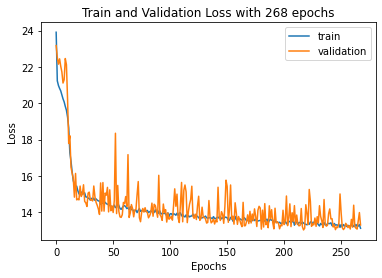

In [49]:
patience=25
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [50]:
#quantitative reuslt: mean square error on test set
mse  

11.73714542388916

In [51]:
predict3=np.zeros((l2r,8))

for i in range(408289,408800):
    predict3[i-408289]=predictions[i]
    
predict2=np.zeros((l2r,8))

for i in range(407778,408289):
    predict2[i-407778]=predictions[i]
    
predict1=np.zeros((l2r,8))

for i in range(407267,407778):
    predict1[i-407267]=predictions[i]

In [52]:
ltype = 'mean_squared_error'
ltype2=tf.keras.metrics.RootMeanSquaredError()
bsize = 1024


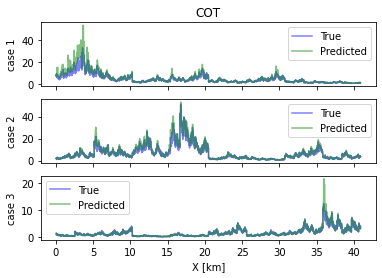

In [53]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+'DNN connection patience50'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo],data[num-3,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict1.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo],data[num-2,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict2.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo],data[num-1,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict3.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')




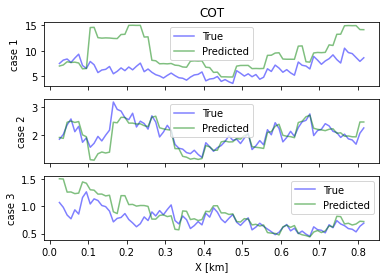

In [54]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_pixels_DNN patience50"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo][:80],data[num-3,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict1.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo][:80],data[num-2,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict2.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo][:80],data[num-1,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo][:80],predict3.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')